# <center> Trabajo Practico N1: Redes Convolucionales </center>
<div>
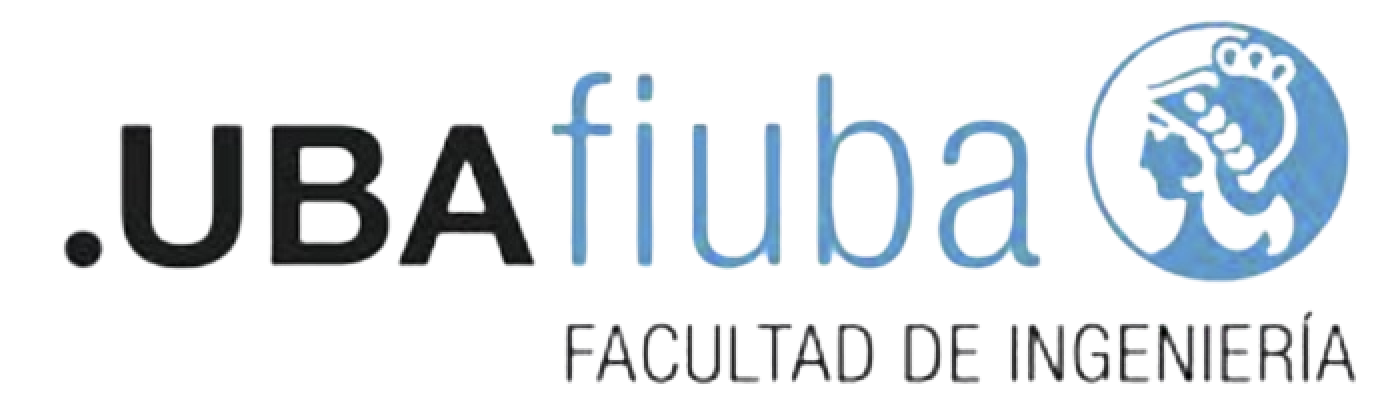
</div>

### <center>José Mornaghi y Lucas Argento</center>
 



> ##  Introducción


Con el objetivo de estudiar las redes neuronales convolucionales, sus aplicaciones y su diseño, se analizó un dataset público sobre imagenes MRI de pacientes con distintos grados de la enfermedad de Alzheimer. El objetivo del estudio fue clasificar las imagenes de entrada en 4 clases distintas, cada una indicando un distinto grado de avance de la enfermedad.

Para esto, se utilizó una red neuronal convolucional, para la cual se estudiaron diferentes decisiones de diseño y valores de sus hiperparamétros.

> ## Sobre los datos

El dataset público "Alzheimer MRI Preprocessed Dataset", disponible en Kaggle, contiene imágenes de 4 clases diferentes en tamaños de 128 x 128 pixeles.

Los datos fueron recolectados de diferentes paginas web, hospitales y repositoros públicos. Consisten en imagánes preprocesdad de resonancias magneticas MRI (por sus siglas en inglés Magnetic Resonance Imaging)

El dataset consiste en un total de 6400 imágenes, pertenecientes a una de las siguientes clases:
Clase - 1: Mild Demented (896 imágenes)
Clase - 2: Moderate Demented (64 imágenes)
Clase - 3: Non Demented (3200 imágenes)
Clase - 4: Very Mild Demented (2240 imágenes)

Elegimos este dataset en particular ya que consideramos que las CNNs tienen un potencial genuino para resolver este tipo de problemas en la vida real, agregando valor y mejorando la vida de las personas. 

Referencias:

* https://adni.loni.usc.edu/
* https://www.alzheimers.net/
* https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers
* https://ieeexplore.ieee.org/document/9521165
* https://catalog.data.gov/dataset/alzheimers-disease-and-healthy-aging-data
* https://www.nature.com/articles/s41598-020-79243-9
* https://cordis.europa.eu/article/id/429468-the-final-epad-dataset-is-now-available-on-the-alzheimer-s-disease-workbench

> ## Librerias a utilizar 

In [1]:
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from utils import train_model, compute_confusion_matrix

from plot_utils import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix

> ## Visualizacion de las clases

Tenemos 4 clases de demencia asociadas a distintos niveles de Alzheimer. A continuacion mostramos ejemplos de MRI's para los distintos niveles mencionados:

In [3]:
class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [3]:
#%pip install ipyplot
import ipyplot

images = ["Dataset/Mild_Demented/mild_10.jpg","Dataset/Moderate_Demented/moderate_10.jpg","Dataset/Non_Demented/non_10.jpg","Dataset/Very_Mild_Demented/verymild_10.jpg"]

ipyplot.plot_images(images, class_names, img_width=150)

> ## Carga de los datos y separación en sets de entrenamiento, validación y testeo

> _Split folders es un paquete que facilita el proceso de hacer un test-train-split con carpetas de imágenes_

In [7]:
#!pip install split-folders
import splitfolders
splitfolders.ratio('Dataset', output="output", seed=123, ratio=(.8, 0.1,0.1))

Copying files: 6400 files [00:02, 2443.30 files/s]


In [4]:
# Como se menciono antes, nuestro dataset contiene imagenes en 128x128
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Transformamos a tensores para poder procesar las imagenes con PyTorch
transform = transforms.ToTensor()

# Transformaciones y loadding
train_data = datasets.ImageFolder(root='output/train',transform=transform)
test_data = datasets.ImageFolder(root='output/test',transform=transform)
val_data = datasets.ImageFolder(root='output/val',transform=transform)

> ## Arquitectura Propuesta

Para el estudio de las CNNs, decidimos partir de la arquitectura original de la Red Neuronal **LeNet** (1998), la cual luego modificaremos para estudiar los efectos de las distintas decisiones de diseño. 
A continuacion, se observa un esquema de la arquitectura original, compuesta por dos capas convolucionales y 3 capas FullyConnected de Perceptrones Multicapa. Si bien la red original usaba funciones de activacion de tangenge hiperbólica, en nuestro caso se utilizaron funciones ReLu.

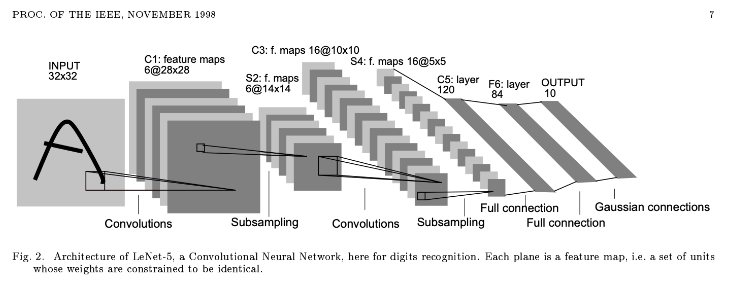

In [79]:
class LeNet5(nn.Module):

    def __init__(self, n_canales_rgb, n_clases, cantidad_filtros_conv, tamaño_filtro_conv, 
                 tamaño_kernel_pooling, stride, padding):
        super().__init__()
        # cantidad de canales y clases, a definir por el diseñador
        self.n_canales_rgb = n_canales_rgb
        self.n_clases = n_clases
        self.tamaño_kernel_pooling = tamaño_kernel_pooling
        # Le net tiene dos capas convolucionales
        self.conv1 = nn.Conv2d(self.n_canales_rgb, cantidad_filtros_conv, kernel_size=tamaño_filtro_conv, stride=stride, padding=padding)
        
        outputconv1 = math.ceil(((128 - tamaño_filtro_conv)/stride))
        # falta un +1 al final ?? tener en cuenta el padding
        # asi seria? outputconv1 = math.ceil(((128 - tamaño_filtro_conv + 2* padding)/stride) + 1)
        
        print("imagenes de salida post convolucion1:", outputconv1, "x", outputconv1)
        outputconv1 = math.ceil(outputconv1 / tamaño_kernel_pooling)
        print("imagenes de salida post pooling1:", outputconv1, "x", outputconv1)
        
        self.conv2 = nn.Conv2d(cantidad_filtros_conv, 16, kernel_size=tamaño_filtro_conv, stride=stride, padding=padding)
        
        outputconv2 = math.ceil(((outputconv1 - tamaño_filtro_conv)/stride))
        print("imagenes de salida post convolucion2:", outputconv2, "x", outputconv2)
        outputconv2 = math.ceil(outputconv2 / tamaño_kernel_pooling)
        print("imagenes de salida post pooling2:", outputconv2, "x", outputconv2)

        # size del vector de parametros luego de las capas convolucionales
        cantidad_parametros = math.ceil(16 * outputconv2 * outputconv2)
        # y tres capas de MLPs
        
        # primer MLP
        inputfc1 = math.ceil(cantidad_parametros)
        print("parametros de entrada del primer perceptron:", inputfc1)
        outputfc1 = math.ceil((3/4)*inputfc1)
        print("parametros de salida del primer perceptron:", outputfc1)
        
        self.fc1 = torch.nn.Linear(inputfc1, outputfc1)
        # segundo MLP
        inputfc2 = outputfc1
        print("parametros de entrada del segundo perceptron:", inputfc2)
        outputfc2 = math.ceil(inputfc2*(1/2))
        print("parametros de salida del segundo perceptron:", outputfc2)
        self.fc2 = torch.nn.Linear(inputfc2, outputfc2)
        # tercer MLP. salida con cantidad de clases
        inputfc3 = outputfc2
        print("parametros de entrada del tercer perceptron:", inputfc3)
        self.fc3 = torch.nn.Linear(inputfc3, self.n_clases)

    def forward(self, x):
        # capa convolucional
        x = self.conv1(x)
        # al resultado de la convolucion, le aplica una ReLu
        x = F.relu(x)
        # y luego un pooling
        x = F.max_pool2d(x, (self.tamaño_kernel_pooling, self.tamaño_kernel_pooling))
        
        # Segunda capa convolucional
        x = self.conv2(x)
        # aplica relu
        x = F.relu(x)
        # pooling 
        x = F.max_pool2d(x, (self.tamaño_kernel_pooling, self.tamaño_kernel_pooling))
        
        # flatten de las imagenes para pasarlo a MLPs
        x = torch.flatten(x, 1)
        # MLPs con relus
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

> _Puesto que variaremos los hiperparametros de nuestra red en reiteradas ocaciones, vamos a modularizar el proceso de creación y entrenamiento del modelo a través de una función_

In [60]:
def crear_modelo(cantidad_filtros_conv, tamaño_filtro_conv, tamaño_kernel_pooling, stride, padding):
    # Instanciamos la clase del modelo:
    model = LeNet5(3, 4, cantidad_filtros_conv, tamaño_filtro_conv, tamaño_kernel_pooling, stride, padding)
    # CUDA / CPU
    model = model.to('cpu')
    return model

In [61]:
def entrenar_modelo(model, optimizer, epocas, batch_size, train_data, val_data, test_data):
    # Cargamos data en PyTorch
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle = True,                                        
                                               num_workers=0)

    valid_loader = torch.utils.data.DataLoader(val_data,
                                               batch_size=batch_size,
                                               shuffle = True,
                                               num_workers=0)

    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              shuffle = True,
                                              num_workers=0)
    
    # Entrenamiento del modelo
    minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
        model=model,
        num_epochs=NUM_EPOCAS,
        train_loader=train_loader,
        valid_loader=valid_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        device='cpu',
        log_interval_batch=5)
    # Devuelvo listas para controlar el desempeño del entrenamiento
    return minibatch_loss_list, train_acc_list, valid_acc_list, train_loader

> _La optimización de la red se realizará con el algoritmo del descenso del gradiente estocástico_

> ## Primer modelo y entrenamiento

In [8]:
model_1= crear_modelo(6, 3, 2, 1, 0)

imagenes de salida post convolucion1: 125 x 125
imagenes de salida post pooling1: 63 x 63
imagenes de salida post convolucion2: 60 x 60
imagenes de salida post pooling2: 30 x 30
parametros de entrada del primer perceptron: 14400
parametros de salida del primer perceptron: 10800
parametros de entrada del segundo perceptron: 10800
parametros de salida del segundo perceptron: 5400
parametros de entrada del tercer perceptron: 5400


In [9]:
#optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.01)

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7407771/#:~:text=The%20Adam%20optimizer%20had%20the,ability%20in%20classification%20and%20segmentation

In [12]:
NUM_EPOCAS = 1
valid_size = 0.2
batch_size = 128

In [13]:
minibatch_loss_list, train_acc_list, valid_acc_list, train_loader = entrenar_modelo(model_1, 
                                                                      optimizer, 
                                                                      NUM_EPOCAS, 
                                                                      batch_size, 
                                                                      train_data, 
                                                                      val_data, 
                                                                      test_data)

salida prop adelante tensor([[-0.3527, -2.1951,  0.5529,  0.4439],
        [-0.2843, -1.5364,  0.3467,  0.3486],
        [-0.1456, -0.7966,  0.2059,  0.1958],
        [-0.2516, -1.4032,  0.3288,  0.3126],
        [-0.2692, -1.5459,  0.3678,  0.3363],
        [-0.2599, -1.4004,  0.3169,  0.3213],
        [-0.3317, -2.1363,  0.5523,  0.4267],
        [-0.2697, -1.4461,  0.3229,  0.3324],
        [-0.2335, -1.2558,  0.2882,  0.2909],
        [-0.2636, -1.4813,  0.3460,  0.3287],
        [-0.2355, -1.3160,  0.3111,  0.2961],
        [-0.3100, -1.7715,  0.4171,  0.3810],
        [-0.3269, -1.9480,  0.4703,  0.4073],
        [-0.2390, -1.4197,  0.3580,  0.3063],
        [-0.1795, -0.9356,  0.2183,  0.2291],
        [-0.2274, -1.2038,  0.2730,  0.2836],
        [-0.3123, -1.9098,  0.4756,  0.3945],
        [-0.2638, -1.4132,  0.3154,  0.3261],
        [-0.3073, -1.8684,  0.4610,  0.3886],
        [-0.2589, -1.5303,  0.3789,  0.3281],
        [-0.2797, -1.5879,  0.3738,  0.3463],
        [-0.1

> Nuestro primer Modelo logra una Accuracy en el Test de Entrenamiento del 56.28%.
Realizamos un solo epoch, un batch size de 128 y un learning rate de 0.01 utilizando Adam Optimizer.

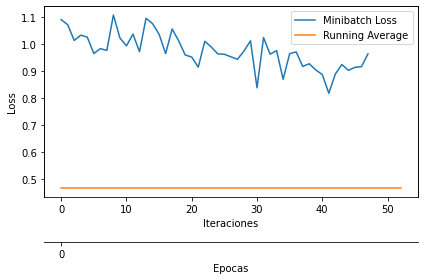

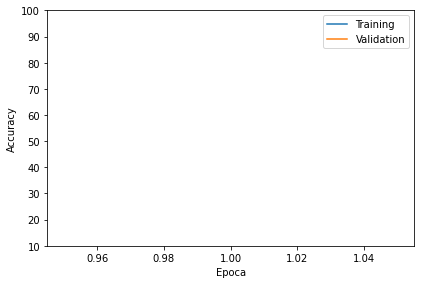

In [14]:
# Plot function de utils
plot_training_loss(minibatch_loss_list = minibatch_loss_list,
                   num_epochs = NUM_EPOCAS,
                   iter_per_epoch = len(train_loader),
                   averaging_iterations = 100)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list)
plt.ylim([10, 100])
plt.show()

> ## Ejercicio 1: Variación de Hiperparámetros


**A) Modificar la cantidad de canales (filtros) de la capa convolucional, el tamaño del kernel de convolución y el tamaño del kernel de pooling.**

Sabemos que existe una relación de dimensiones entre el tamaño del kernel de convolución, la cantidad de filtros y el tamaño del kernel de pooling, el stride y el padding.\
En la siguiente imágen podemos observar como se relacionan estos parámetros, capa a capa.

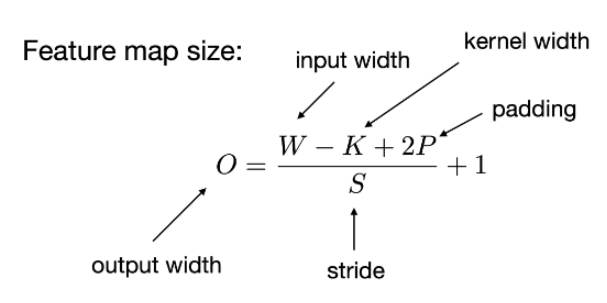

Luego de la última capa de convolución, se realiza un unrolling de los parametros para vectorizarlos y poder ingresarlos al primer perceptron (primera capa fully connected).\
Dicho vector de parametros tendra un tamaño de **FeatureMapSizeLastConv** x **FeatureMapSizeLastConv** x **CantidadFiltrosLastConv**.\
Donde **FeatureMapSizeLastConv** es la dimension de las imágenes luego de la ultima capa de convolución y pooling (las capas de pooling dividen la dimension en N veces, siendo N la dimensión del filtro de pooling).

Cada perceptron debera recibir como input la cantidad de parametros de salida de la capa anterior, y el ultimo de ellos debera tener como output la cantidad de clases a predecir, en el ejemplo de un problema de clasificación.

In [23]:
model_2 = crear_modelo(8, 2, 2, 1, 0)
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01)
NUM_EPOCAS = 1
valid_size = 0.2
batch_size = 128

imagenes de salida post convolucion1: 126 x 126
imagenes de salida post pooling1: 63 x 63
imagenes de salida post convolucion2: 61 x 61
imagenes de salida post pooling2: 31 x 31
parametros de entrada del primer perceptron: 15376
parametros de salida del primer perceptron: 11532
parametros de entrada del segundo perceptron: 11532
parametros de salida del segundo perceptron: 5766
parametros de entrada del tercer perceptron: 5766


In [24]:
minibatch_loss_list, train_acc_list, valid_acc_list, train_loader = entrenar_modelo(model_2, 
                                                                      optimizer, 
                                                                      NUM_EPOCAS, 
                                                                      batch_size, 
                                                                      train_data, 
                                                                      val_data, 
                                                                      test_data)

salida prop adelante tensor([[-3.7730e-02, -4.8849e-03, -3.6930e-04,  2.1216e-02],
        [-3.9172e-02, -8.1808e-03,  6.3588e-03,  2.2899e-02],
        [-3.5205e-02, -9.6564e-03,  2.6747e-03,  2.3795e-02],
        [-3.6290e-02, -1.1622e-02, -9.6755e-04,  2.5296e-02],
        [-3.3000e-02, -3.8497e-03, -1.5234e-03,  2.3932e-02],
        [-3.6863e-02, -7.6248e-03,  2.9508e-03,  2.4886e-02],
        [-3.1121e-02, -2.1977e-03, -1.2848e-03,  2.1266e-02],
        [-3.2487e-02, -3.9840e-03, -3.1736e-03,  2.4705e-02],
        [-3.1645e-02, -5.8901e-03, -1.9050e-05,  2.3264e-02],
        [-3.7259e-02, -1.0187e-02,  2.7266e-03,  2.2134e-02],
        [-3.8157e-02, -5.2790e-03,  8.1117e-04,  2.4118e-02],
        [-3.4670e-02, -9.3518e-03, -1.6618e-03,  2.5440e-02],
        [-3.9648e-02, -1.0352e-02,  6.6202e-04,  2.3251e-02],
        [-3.1646e-02, -7.2330e-03, -2.5195e-04,  1.8975e-02],
        [-3.4466e-02, -6.8580e-03, -3.3255e-04,  2.3175e-02],
        [-3.2192e-02, -5.8809e-03,  3.8639e-03,  

>En nuestro modelo definido anteriormente, harcodeamos el valor de la cantidad de filtros convolucionales de la segunda capa.\
Dejando este valor estatico en 16, y aumentando la cantidad de filtros de la primer capa, y achicando el tamaño del filtro empeoro la performance.

> Nuevo Modelo en el cual vamos a iterar cambiando solo el tamaño del filtro convolucional.

In [26]:
model_3 = crear_modelo(8, 4, 2, 1, 0)
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.01)
NUM_EPOCAS = 1
valid_size = 0.2
batch_size = 128

imagenes de salida post convolucion1: 124 x 124
imagenes de salida post pooling1: 62 x 62
imagenes de salida post convolucion2: 58 x 58
imagenes de salida post pooling2: 29 x 29
parametros de entrada del primer perceptron: 13456
parametros de salida del primer perceptron: 10092
parametros de entrada del segundo perceptron: 10092
parametros de salida del segundo perceptron: 5046
parametros de entrada del tercer perceptron: 5046


In [27]:
minibatch_loss_list, train_acc_list, valid_acc_list, train_loader = entrenar_modelo(model_3, 
                                                                      optimizer, 
                                                                      NUM_EPOCAS, 
                                                                      batch_size, 
                                                                      train_data, 
                                                                      val_data, 
                                                                      test_data)

salida prop adelante tensor([[-2.1444e-04,  3.3949e-03,  5.1958e-03,  1.8609e-03],
        [-6.4670e-04,  2.5736e-03,  7.7029e-03, -1.2360e-04],
        [-1.3059e-03,  1.3223e-03,  6.5772e-03, -1.3416e-03],
        [ 2.7153e-04,  3.1080e-03,  4.9696e-03, -3.7752e-04],
        [ 8.9663e-04,  3.0767e-04,  6.3157e-03,  1.6172e-03],
        [-2.0318e-03,  2.2007e-03,  6.1040e-03, -9.0036e-04],
        [-2.1709e-03,  1.0170e-03,  6.7558e-03, -3.9353e-04],
        [-5.4141e-04,  2.6733e-03,  5.5524e-03, -2.7364e-04],
        [-7.2926e-04,  2.3451e-03,  5.4268e-03, -1.3834e-03],
        [-3.4223e-03,  1.3733e-03,  3.5992e-03,  6.0526e-04],
        [-7.8180e-04,  6.7761e-04,  7.7949e-03, -3.6260e-04],
        [-2.4389e-03,  2.8307e-03,  2.7969e-03,  1.1976e-03],
        [-1.0174e-03,  4.5091e-04,  3.9233e-03, -1.2975e-05],
        [-5.3463e-03,  1.1302e-03,  8.0235e-03, -1.4599e-03],
        [-1.1393e-03,  2.5077e-03,  6.0824e-03, -4.1949e-04],
        [-2.2442e-04,  3.6342e-03,  6.3272e-03,  

> Realizar un cambio de tamaño del filtro en comparacion con el modelo anterior, de 2x2 a 4x4, no nos otorgo ninguna mejoria. El modelo tiene la misma capacidad de predicción.

**B) Incorporar padding y stride distintos a los valores por defecto. Explicar en qué consisten estos conceptos**

El **Stride** es, en pocas palabras, el desplazamiento del filtro convolucional a traves de la imagen.\
El **Padding** es una tecnica que aumenta los bordes de las imagenes, matricialmente agregando ceros en las esquinas para que el filtro tenga mayor libertad de desplazamiento y pueda darse una mejor capacidad de prediccion

In [45]:
model_4= crear_modelo(6, 3, 2, 2, 0)
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.01)
NUM_EPOCAS = 1
valid_size = 0.2
batch_size = 128

imagenes de salida post convolucion1: 64 x 64
imagenes de salida post pooling1: 32 x 32
imagenes de salida post convolucion2: 16 x 16
imagenes de salida post pooling2: 8 x 8
parametros de entrada del primer perceptron: 1024
parametros de salida del primer perceptron: 768
parametros de entrada del segundo perceptron: 768
parametros de salida del segundo perceptron: 384
parametros de entrada del tercer perceptron: 384


In [ ]:
minibatch_loss_list, train_acc_list, valid_acc_list, train_loader = entrenar_modelo(model_4, 
                                                                      optimizer, 
                                                                      NUM_EPOCAS, 
                                                                      batch_size, 
                                                                      train_data, 
                                                                      val_data, 
                                                                      test_data)

In [48]:
model_5= crear_modelo(6, 3, 2, 1, 1)
optimizer = torch.optim.Adam(model_5.parameters(), lr=0.01)
NUM_EPOCAS = 1
valid_size = 0.2
batch_size = 128

imagenes de salida post convolucion1: 126 x 126
imagenes de salida post pooling1: 63 x 63
imagenes de salida post convolucion2: 61 x 61
imagenes de salida post pooling2: 31 x 31
parametros de entrada del primer perceptron: 15376
parametros de salida del primer perceptron: 11532
parametros de entrada del segundo perceptron: 11532
parametros de salida del segundo perceptron: 5766
parametros de entrada del tercer perceptron: 5766


In [ ]:
minibatch_loss_list, train_acc_list, valid_acc_list, train_loader = entrenar_modelo(model_5, 
                                                                      optimizer, 
                                                                      NUM_EPOCAS, 
                                                                      batch_size, 
                                                                      train_data, 
                                                                      val_data, 
                                                                      test_data)

**C) Dibujar la curva de la función costo en función de los pasos de entrenamiento. Variar el valor de la constante de aprendizaje (learning rate) y comentar si se observan diferencias en el comportamiento de la curva**

In [65]:
model_6= crear_modelo(6, 3, 2, 1, 0)
optimizer = torch.optim.Adam(model_6.parameters(), lr=0.001)
NUM_EPOCAS = 1
valid_size = 0.2
batch_size = 128

imagenes de salida post convolucion1: 125 x 125
imagenes de salida post pooling1: 63 x 63
imagenes de salida post convolucion2: 60 x 60
imagenes de salida post pooling2: 30 x 30
parametros de entrada del primer perceptron: 14400
parametros de salida del primer perceptron: 10800
parametros de entrada del segundo perceptron: 10800
parametros de salida del segundo perceptron: 5400
parametros de entrada del tercer perceptron: 5400


In [66]:
minibatch_loss_list, train_acc_list, valid_acc_list, train_loader = entrenar_modelo(model_6, 
                                                                      optimizer, 
                                                                      NUM_EPOCAS, 
                                                                      batch_size, 
                                                                      train_data, 
                                                                      val_data, 
                                                                      test_data)

salida prop adelante tensor([[-0.0113,  0.0091, -0.0080, -0.0181],
        [-0.0097,  0.0089, -0.0083, -0.0172],
        [-0.0081,  0.0089, -0.0078, -0.0137],
        [-0.0065,  0.0091, -0.0064, -0.0162],
        [-0.0111,  0.0066, -0.0096, -0.0164],
        [-0.0125,  0.0112, -0.0070, -0.0158],
        [-0.0088,  0.0070, -0.0080, -0.0157],
        [-0.0095,  0.0115, -0.0108, -0.0141],
        [-0.0101,  0.0092, -0.0075, -0.0182],
        [-0.0125,  0.0091, -0.0114, -0.0102],
        [-0.0114,  0.0105, -0.0089, -0.0177],
        [-0.0086,  0.0069, -0.0093, -0.0161],
        [-0.0070,  0.0088, -0.0083, -0.0162],
        [-0.0104,  0.0080, -0.0068, -0.0172],
        [-0.0102,  0.0087, -0.0092, -0.0178],
        [-0.0132,  0.0085, -0.0078, -0.0131],
        [-0.0137,  0.0127, -0.0093, -0.0149],
        [-0.0117,  0.0124, -0.0092, -0.0148],
        [-0.0140,  0.0106, -0.0102, -0.0124],
        [-0.0146,  0.0097, -0.0085, -0.0132],
        [-0.0098,  0.0074, -0.0055, -0.0162],
        [-0.0

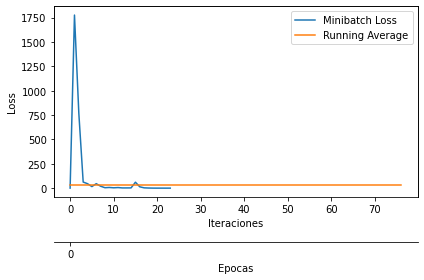

In [72]:
# Plot function de utils
plot_training_loss(minibatch_loss_list = minibatch_loss_list,
                   num_epochs = NUM_EPOCAS,
                   iter_per_epoch = len(train_loader),
                   averaging_iterations = 100)
plt.show()

> Al variar el Learning rate, de 0.01 a 0.001 podemos visualizar cuanto mas rapido converge a un valor de Loss cercano a cero.\
El grafico de abajo muestra el primer modelo.

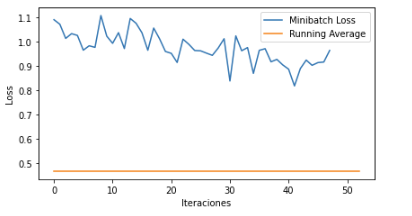

**D) Cambiar el parámetro _batch_size_ y explicar por qué varía la cantidad de pasos en el entrenamiento al modificarlo**

> El batch_size es un subconjunto de los datos de entrenamiento que tomamos para entrenar.\
Existen dos approaches: entrenar nuestro data set en su totalidad o bien definir subconjuntos de menor dimension que utilizaremos para entrenar iterando sobre el total de datos. Cuanto mayor sea el batch_size, menor cantidad de pasos haran falta para cubrir la totalidad del dataset de entrenamiento.\
El valor de entrenar con batches reside en la capacidad de con menor cantidad de datos poder arribar a un resultado similar, con un costo computacional y de tiempo menor. Ganando además la capacidad de tomar decisiones intra-steps del entrenamiento. 

In [75]:
model_7= crear_modelo(6, 3, 2, 1, 0)
optimizer = torch.optim.Adam(model_7.parameters(), lr=0.001)
NUM_EPOCAS = 1
valid_size = 0.2
batch_size = 510

imagenes de salida post convolucion1: 125 x 125
imagenes de salida post pooling1: 63 x 63
imagenes de salida post convolucion2: 60 x 60
imagenes de salida post pooling2: 30 x 30
parametros de entrada del primer perceptron: 14400
parametros de salida del primer perceptron: 10800
parametros de entrada del segundo perceptron: 10800
parametros de salida del segundo perceptron: 5400
parametros de entrada del tercer perceptron: 5400


In [76]:
minibatch_loss_list, train_acc_list, valid_acc_list, train_loader = entrenar_modelo(model_7, 
                                                                      optimizer, 
                                                                      NUM_EPOCAS, 
                                                                      batch_size, 
                                                                      train_data, 
                                                                      val_data, 
                                                                      test_data)

salida prop adelante tensor([[ 0.0083,  0.0060, -0.0009, -0.0004],
        [ 0.0086,  0.0063, -0.0017, -0.0006],
        [ 0.0082,  0.0052, -0.0018, -0.0006],
        ...,
        [ 0.0090,  0.0052, -0.0024, -0.0005],
        [ 0.0087,  0.0058, -0.0009, -0.0002],
        [ 0.0092,  0.0049, -0.0013, -0.0010]], grad_fn=<AddmmBackward0>)
Targets tensor([2, 2, 3, 3, 3, 2, 2, 3, 0, 3, 2, 3, 2, 3, 2, 2, 2, 0, 2, 3, 3, 0, 2, 2,
        2, 3, 2, 2, 2, 2, 3, 2, 0, 3, 3, 3, 3, 2, 2, 0, 3, 2, 3, 2, 2, 3, 3, 2,
        3, 2, 0, 3, 2, 3, 3, 3, 0, 2, 3, 0, 2, 0, 3, 2, 3, 2, 0, 2, 3, 0, 2, 2,
        0, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 0, 2, 0, 3, 0, 3, 3, 3, 3, 2, 3, 3,
        3, 3, 0, 2, 2, 0, 3, 2, 2, 2, 3, 2, 3, 0, 2, 2, 0, 2, 2, 3, 2, 2, 2, 3,
        3, 0, 2, 2, 3, 3, 0, 0, 2, 3, 3, 3, 3, 3, 2, 2, 3, 0, 2, 3, 2, 3, 3, 2,
        3, 3, 2, 2, 3, 2, 2, 2, 0, 2, 0, 2, 2, 2, 3, 3, 3, 2, 3, 2, 0, 0, 3, 0,
        2, 2, 2, 0, 2, 0, 0, 0, 2, 3, 3, 3, 3, 2, 0, 2, 2, 2, 2, 3, 3, 2, 2, 2,
        2, 0, 0

**E) Aumentar la cantidad de _epocs_. Observar cómo se comportan las curvas de aprendizaje**

In [77]:
model_8= crear_modelo(6, 3, 2, 1, 0)
optimizer = torch.optim.Adam(model_8.parameters(), lr=0.01)
NUM_EPOCAS = 4
valid_size = 0.2
batch_size = 128

imagenes de salida post convolucion1: 125 x 125
imagenes de salida post pooling1: 63 x 63
imagenes de salida post convolucion2: 60 x 60
imagenes de salida post pooling2: 30 x 30
parametros de entrada del primer perceptron: 14400
parametros de salida del primer perceptron: 10800
parametros de entrada del segundo perceptron: 10800
parametros de salida del segundo perceptron: 5400
parametros de entrada del tercer perceptron: 5400


In [78]:
minibatch_loss_list, train_acc_list, valid_acc_list, train_loader = entrenar_modelo(model_8, 
                                                                      optimizer, 
                                                                      NUM_EPOCAS, 
                                                                      batch_size, 
                                                                      train_data, 
                                                                      val_data, 
                                                                      test_data)

salida prop adelante tensor([[ 1.4907e-02, -6.2875e-03, -1.7879e-03, -1.6561e-02],
        [ 1.4333e-02, -3.9968e-03,  1.5804e-03, -1.2218e-02],
        [ 1.7029e-02, -4.7802e-03,  5.0411e-03, -1.6202e-02],
        [ 1.6036e-02, -7.0659e-03,  1.4610e-03, -1.4139e-02],
        [ 1.5743e-02, -8.4733e-03, -3.9817e-03, -1.2882e-02],
        [ 2.0589e-02, -2.9120e-03,  7.7432e-03, -1.5075e-02],
        [ 1.8893e-02, -6.5507e-03,  4.4523e-03, -9.8895e-03],
        [ 1.5156e-02, -5.4654e-03, -4.7108e-03, -1.4439e-02],
        [ 1.7397e-02, -7.5848e-03,  2.6191e-03, -1.2157e-02],
        [ 1.9539e-02, -7.5868e-03,  2.9527e-03, -9.9890e-03],
        [ 1.7992e-02, -6.6291e-03, -6.4325e-04, -1.1896e-02],
        [ 1.4036e-02, -6.0016e-03, -2.5313e-03, -1.6312e-02],
        [ 1.8445e-02, -9.2310e-03,  3.2398e-03, -9.1433e-03],
        [ 1.4682e-02, -4.0972e-03,  1.3920e-03, -1.6049e-02],
        [ 2.2794e-02, -6.5199e-03,  2.0533e-03, -8.8205e-03],
        [ 1.8240e-02, -4.2411e-03,  4.4730e-03, -

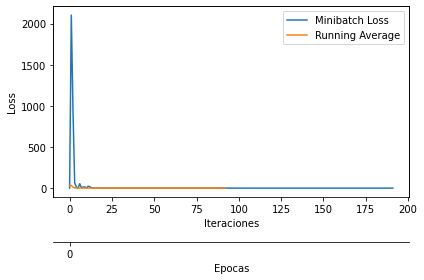

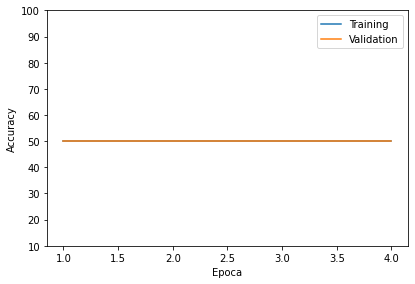

In [81]:
plot_training_loss(minibatch_loss_list = minibatch_loss_list,
                   num_epochs = NUM_EPOCAS,
                   iter_per_epoch = len(train_loader),
                   averaging_iterations = 100)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list)
plt.ylim([10, 100])
plt.show()

> Aumentar la cantidad de epochs no contribuye a nada. Si observamos los pasos que realiza nuestra red, en un momento deja de poder predecir distintas clases, y para cada batch nuevo predice la misma clase para todo el batch.

**F) Agregar una capa convolucional, una capa de max pooling y una capa lineal de manera tal que la red siga funcionando. Explicar la elección de dimensiones para que la red sea funcional.**

La relación de dimensiones fue explicada anteriormente, a continuación definimos una nueva arquitectura en base a lo solicitado:

In [82]:
class LeMateNet(nn.Module):
    # aguante el mate
    def __init__(self, n_canales_rgb, n_clases, cantidad_filtros_conv, tamaño_filtro_conv, 
                 tamaño_kernel_pooling, stride, padding):
        super().__init__()
        # cantidad de canales y clases, a definir por el diseñador
        self.n_canales_rgb = n_canales_rgb
        self.n_clases = n_clases
        self.tamaño_kernel_pooling = tamaño_kernel_pooling
        
        # LeNet tiene dos capas convolucionales, le agregamos una tercera
        
        self.conv1 = nn.Conv2d(self.n_canales_rgb, cantidad_filtros_conv, kernel_size=tamaño_filtro_conv, stride = stride, padding = padding)
        
        outputconv1 = math.ceil(((128 - tamaño_filtro_conv)/stride))
        outputconv1 = math.ceil(outputconv1 / tamaño_kernel_pooling)
        
        self.conv2 = nn.Conv2d(cantidad_filtros_conv, 16, kernel_size=tamaño_filtro_conv, stride = stride, padding = padding)
        
        outputconv2 = math.ceil((outputconv1 - tamaño_filtro_conv /stride))
        outputconv2 = math.ceil(outputconv2 / tamaño_kernel_pooling)
        
        # capa nueva de convolucion y max pooling
        
        self.conv3 = nn.Conv2d(16, 24, kernel_size=tamaño_filtro_conv, stride = stride, padding = padding)
        
        outputconv3 = math.ceil((outputconv2 - tamaño_filtro_conv /stride))
        outputconv3 = math.ceil(outputconv3 / tamaño_kernel_pooling)
        
        # size del vector de parametros luego de las capas convolucionales
        cantidad_parametros = math.ceil(24 * outputconv3 * outputconv3)
        # y tres capas de MLPs
        
        # primer MLP
        inputfc1 = math.ceil(cantidad_parametros)
        outputfc1 = math.ceil((3/4)*inputfc1)
        
        self.fc1 = torch.nn.Linear(inputfc1, outputfc1)
        # segundo MLP
        inputfc2 = outputfc1
        outputfc2 = math.ceil(inputfc2*(1/2))
        self.fc2 = torch.nn.Linear(inputfc2, outputfc2)
        # tercer MLP. 
        inputfc3 = outputfc2
        outputfc3 = math.ceil(inputfc3/2)
        self.fc3 = torch.nn.Linear(inputfc3, outputfc3)
        # Nuevo y ultimo MLP. salida con cantidad de clases
        inputfc4 = outputfc3
        self.fc4 = torch.nn.Linear(inputfc4, self.n_clases)

    def forward(self, x):
        # capa convolucional
        x = self.conv1(x)
        # al resultado de la convolucion, le aplica una ReLu
        x = F.relu(x)
        # y luego un pooling
        x = F.max_pool2d(x, (self.tamaño_kernel_pooling, self.tamaño_kernel_pooling))
        
        # Segunda capa convolucional
        x = self.conv2(x)
        # aplica relu
        x = F.relu(x)
        # pooling 
        x = F.max_pool2d(x, (self.tamaño_kernel_pooling, self.tamaño_kernel_pooling))
        
        # Tercera capa convolucional
        x = self.conv3(x)
        # aplica relu
        x = F.relu(x)
        # pooling 
        x = F.max_pool2d(x, (self.tamaño_kernel_pooling, self.tamaño_kernel_pooling))
        
        
        # flatten de las imagenes para pasarlo a MLPs
        x = torch.flatten(x, 1)
        # MLPs con relus
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x) #output 4 clases :)
        
        return x

In [88]:
def crear_modeloMATE(cantidad_filtros_conv, tamaño_filtro_conv, tamaño_kernel_pooling, stride, padding):
    # Instanciamos la clase del modelo:
    model = LeMateNet(3, 4, cantidad_filtros_conv, tamaño_filtro_conv, tamaño_kernel_pooling, stride, padding)
    # CUDA / CPU
    model = model.to('cpu')
    return model

# le mate net
model_9 = crear_modeloMATE(6, 3, 2, 1, 0)

NUM_EPOCAS = 1
valid_size = 0.2
batch_size = 128
optimizer = torch.optim.Adam(model_9.parameters(), lr=0.01)

In [89]:
minibatch_loss_list, train_acc_list, valid_acc_list, train_loader = entrenar_modelo(model_9,
                                                                                    optimizer,
                                                                                    NUM_EPOCAS,
                                                                                    batch_size,
                                                                                    train_data,
                                                                                    val_data,
                                                                                    test_data)

salida prop adelante tensor([[-0.0053, -0.0096, -0.0123, -0.0301],
        [-0.0052, -0.0103, -0.0129, -0.0297],
        [-0.0053, -0.0097, -0.0129, -0.0309],
        [-0.0059, -0.0105, -0.0129, -0.0295],
        [-0.0059, -0.0109, -0.0122, -0.0298],
        [-0.0061, -0.0105, -0.0123, -0.0297],
        [-0.0053, -0.0103, -0.0133, -0.0309],
        [-0.0050, -0.0095, -0.0122, -0.0293],
        [-0.0052, -0.0097, -0.0129, -0.0295],
        [-0.0053, -0.0097, -0.0125, -0.0297],
        [-0.0054, -0.0106, -0.0128, -0.0300],
        [-0.0054, -0.0102, -0.0124, -0.0289],
        [-0.0058, -0.0109, -0.0125, -0.0298],
        [-0.0055, -0.0108, -0.0131, -0.0308],
        [-0.0054, -0.0100, -0.0119, -0.0298],
        [-0.0051, -0.0099, -0.0122, -0.0296],
        [-0.0055, -0.0103, -0.0129, -0.0290],
        [-0.0050, -0.0101, -0.0119, -0.0296],
        [-0.0051, -0.0098, -0.0127, -0.0297],
        [-0.0056, -0.0100, -0.0119, -0.0301],
        [-0.0050, -0.0098, -0.0124, -0.0295],
        [-0.0

**G) Reemplazar la red convolucional por un perceptrón multicapa. Variar la cantidad de capass y neuronaes y comprar los resultados**

In [93]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(128 * 128 * 3, 24576)
        self.fc2 = nn.Linear(24576, 12288)
        self.fc3 = nn.Linear(6144, 3072)
        self.fc4 = nn.Linear(3072, 1536)
        self.fc5 = nn.Linear(1536, 4)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 128 * 128 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.softmax(self.fc5(x), dim=1)
        return x

modelMLP = Net()
print(modelMLP)

Net(
  (fc1): Linear(in_features=49152, out_features=24576, bias=True)
  (fc2): Linear(in_features=24576, out_features=12288, bias=True)
  (fc3): Linear(in_features=6144, out_features=3072, bias=True)
  (fc4): Linear(in_features=3072, out_features=1536, bias=True)
  (fc5): Linear(in_features=1536, out_features=4, bias=True)
)


In [94]:
# especificar funcion de perdida
criterion = nn.CrossEntropyLoss()

# algoritmo de optimizacion: descenso del gradiente
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=0.01)


In [95]:
# cantidad de epocas a entrenar el modelo
n_epochs = 2

# habilitar modelo para training (actualizacion de gradientes)
modelMLP.train()

for epoch in range(n_epochs):
    # para monitorear el loss 
    train_loss = 0.0
    
    for data, target in train_loader:
        # borrar gradientes
        optimizer.zero_grad()
        
        # propagacion hacia adelante
        output = modelMLP(data)
        
        # calcular salida de funcion de perdida
        loss = criterion(output, target)
        
        # propagacion hacia atras
        loss.backward()
        
        # actualizacion de parametros
        optimizer.step()
        
        # actualizar valor de loss
        train_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoca: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x12288 and 6144x3072)

> ## Ejercicio 2: Regularización


**A) Implementar _dropout_ y _penalidad L2_. Explicar ambos conceptos**

> ## Ejercicio 3: Validación


**A) Armar un set de validación separando parte del set de entrenamiento.**

Lo realizamos desde el inicio. Nos permite iterar momento a momento en el Train Set para observar como nuestro modelo va ajustando en base al Optimizer.\
No utilizar un set de validacion obliga a recorrer el Train Set de principio a fin antes de Testearlo. Puede ser computacionalmente muy intenso, y llevar mucho timepo.

**B) Implementar _early stopping_. Explicar para que sirve**